In [10]:
import math
import os
import sys
sys.path.append("..")
import random
import numpy as np
import torch
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torchvision.transforms as T
from source.cliploss import Loss
from source.beziercurve import CurveSet
from source.diffrasterizer import rasterize_spheres
from source.imagesampler import ImageSampler
from source.initalizer import random_short_lines
from source.trainer import Trainer
from types import SimpleNamespace


In [ ]:
#Important Hyperparameters
batch_size = 1
epochs = 400
inner_steps = 30
thickness = 0.01
learning_rate = 0.001
data_name = 'duck'
clip_conv_layer_weights=[0, 0, 1.0, 1.0, 0.0]
clip_fc_loss_weight=0.1
clip_weight=1.0
clip_conv_loss=1.0
n_curves = 20
radius   = 0.7    # how far out to place each line from center
length   = 0.01    # how long each line is
overlap = 0.6

In [ ]:
# --- Settings ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
width, height = 224, 224
save_dir = Path('training_frames')
save_dir.mkdir(exist_ok=True)
# --- Prepare data sampler for a single scene ---
transforms_json = '../data/{}/transforms_train.json'.format(data_name)
image_dir = '../data/{}/rgb'.format(data_name)
sampler = ImageSampler(
    transforms_json=transforms_json,
    image_dir=image_dir,
    width=width,
    height=height,
    total_iters=0,  # unused in random sampling
    device=device,
)

# --- Prepare loss and rasterizer ---
args = SimpleNamespace(
    device=device,
    percep_loss='none',
    train_with_clip=True,
    clip_weight=clip_weight,
    start_clip=0,
    clip_conv_loss=clip_conv_loss,
    clip_fc_loss_weight=clip_fc_loss_weight,
    clip_text_guide=0.0,
    num_aug_clip=4,
    augemntations=['affine'],
    include_target_in_aug=False,
    augment_both=False,
    clip_model_name='ViT-B/32',
    clip_conv_loss_type='L2',
    clip_conv_layer_weights=clip_conv_layer_weights
)
criterion = Loss(args).to(device)
rasterizer = torch.compile(rasterize_spheres)
center_t = torch.tensor(sampler.scene_center,
                        device=device, dtype=torch.float32)
init_pts = random_short_lines(center_t, n_curves, radius, length, device)
curve_set = CurveSet(init_pts,
                     thickness=thickness,
                     overlap=overlap,
                     arc_samples=300,
                     device=device).to(device)
optimizer = optim.Adam(curve_set.parameters(), lr=learning_rate)


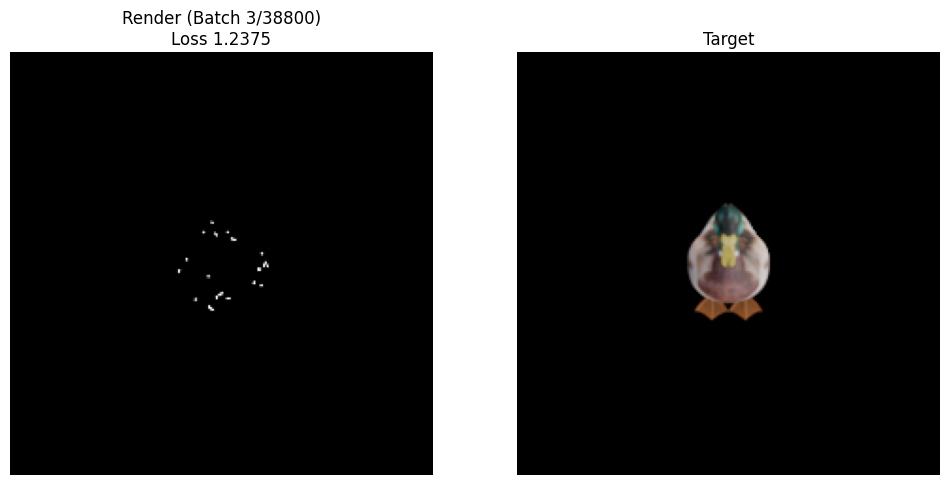

KeyboardInterrupt: 

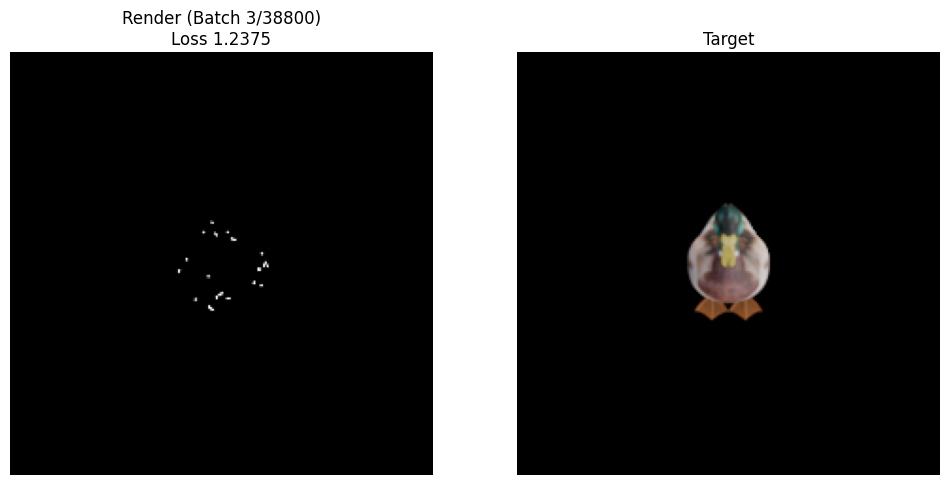

In [ ]:
trainer = Trainer(
    sampler,
    curve_set,
    rasterizer,
    criterion,
    optimizer,
    batch_size=batch_size,
    inner_steps=inner_steps,
    epochs=epochs,
    width=width,
    height=height,
    save_dir=save_dir,
    display_plots=True
)
means, thicknesses = trainer.train()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_spheres_matplotlib(
    means: np.ndarray,
    radii: np.ndarray,
    resolution: int = 20,
    alpha: float = 0.6,
    colormap: str = "viridis"
):
    """
    Plot 3D spheres centered at `means` with given `radii`, using Matplotlib.

    Args:
        means      (N,3) numpy array of sphere centers
        radii      (N,)  numpy array of sphere radii
        resolution number of subdivisions in θ,ϕ (higher → smoother)
        alpha      transparency of each sphere
        colormap   name of a matplotlib colormap for coloring spheres
    """
    # parameterize a unit sphere
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    uu, vv = np.meshgrid(u, v)

    fig = plt.figure(figsize=(5, 5),dpi = 600)
    ax = fig.add_subplot(111, projection="3d")

    cmap = plt.get_cmap(colormap)
    N = len(means)

    for i, ((x0, y0, z0), r) in enumerate(zip(means, radii)):
        # compute sphere surface
        x = x0 + r * np.cos(uu) * np.sin(vv)
        y = y0 + r * np.sin(uu) * np.sin(vv)
        z = z0 + r * np.cos(vv)

        # pick a color from the colormap
        color = cmap(i / max(1, N - 1))  # RGBA tuple
        # now build a (res,res,4) array of that color
        fc = np.broadcast_to(np.array(color)[None, None, :], x.shape + (4,))

        ax.plot_surface(
            x, y, z,
            rstride=1, cstride=1,
            facecolors=fc,
            edgecolor='k',    # draw black edges
            linewidth=0.2,    # thin lines
            shade=True,
            alpha=alpha
        )

    # equal aspect ratio
    xyz = np.vstack([means + radii[:, None], means - radii[:, None]])
    x_limits = (xyz[:, 0].min(), xyz[:, 0].max())
    y_limits = (xyz[:, 1].min(), xyz[:, 1].max())
    z_limits = (xyz[:, 2].min(), xyz[:, 2].max())
    max_range = np.array([
        x_limits[1] - x_limits[0],
        y_limits[1] - y_limits[0],
        z_limits[1] - z_limits[0],
    ]).max() / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    #ax.set_xlim(mid_x - max_range, mid_x + max_range)
    #ax.set_ylim(mid_y - max_range, mid_y + max_range)
    #ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.grid(False)

    plt.tight_layout()
    plt.savefig("3D_spheres_plot.png", dpi=600)
    plt.show()

In [ ]:
means_np = means.detach().cpu().numpy()
radii_np = thicknesses.detach().cpu().numpy()
plot_spheres_matplotlib(means_np, radii_np*2, resolution=5, alpha=1.0)

In [ ]:
from PIL import Image as PILImage

# Gather and sort saved frames
frame_paths = sorted(save_dir.glob("batch_*.png"))
frames = [PILImage.open(p) for p in frame_paths]

# Save GIF
gif_path = "training_evolution.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
print(f"GIF saved to {gif_path}")